<a href="https://colab.research.google.com/github/lukas-plojhar/Rhomberg-v2/blob/main/Rhomberg_v2_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import numpy as np

data = []
with open('/content/text.log.json') as f:
  for line in f:
        data.append(json.loads(line))

print(data[0])

# Time
data_time = [x['data_time'] for x in data]
train_time = [x['time'] for x in data]

mean_data_time = round(np.mean(data_time), 3)
mean_train_time = round(np.mean(train_time), 3)

# Loss
train_loss = [x['train_loss'] for x in data]
# val_loss = [x['val_loss'] for x in data]

mean_train_loss = round(np.mean(train_loss), 3)
# mean_val_loss = round(np.mean(val_loss), 3)

print(f'Average train loss = {mean_train_loss}')
# print(f'Average val loss = {mean_val_loss}')

{'mode': 'train', 'epoch': 1, 'iter': 1, 'lr': 0.02, 'memory': 9191, 'data_time': 0.35935, 'train_loss': 1.81551, 'time': 2.18629}
Average train loss = 0.698


In [ ]:
import json
import numpy as np

data = []
with open('/content/r50text.log.json') as f:
  for line in f:
        data.append(json.loads(line))

print(data[0])

# Time
data_time = [x['data_time'] for x in data]
train_time = [x['time'] for x in data]

mean_data_time = round(np.mean(data_time), 3)
mean_train_time = round(np.mean(train_time), 3)

# Loss
train_loss = [x['train_loss'] for x in data]
# val_loss = [x['val_loss'] for x in data]

mean_train_loss = round(np.mean(train_loss), 3)
# mean_val_loss = round(np.mean(val_loss), 3)

print(f'Average train loss = {mean_train_loss}')
# print(f'Average val loss = {mean_val_loss}')

{'mode': 'train', 'epoch': 1, 'iter': 1, 'lr': 0.02, 'memory': 8121, 'data_time': 0.51343, 'train_loss': 1.79768, 'time': 1.49411}
Average train loss = 0.7


In [ ]:
from pycocotools.coco import COCO
from PIL import Image, ImageDraw
import json
import numpy as np
from sklearn.metrics import PrecisionRecallDisplay

Load JSON data

In [ ]:
# Load data
with open('/content/test_annotations.json') as f:
  gt = json.load(f)
  images = gt['images']
  gt = gt['annotations']

with open('/content/cmask_r50.bbox.json') as f:
  pred = json.load(f)

with open('/content/r50_3e_8ksample.segm.json') as f:
  pred_segm = json.load(f)

Helper functions

In [ ]:
def filter_anns_by_iou(gt: list, pred: list, iou_threshold: float) -> list:
  result = list()

  # Iterate over preds
  for p in pred:
    # Iterate over gts
    for g in gt:
      # print(g)
      iou_value = iou(p['bbox'], g['bbox'])
      if iou_value >= iou_threshold:
        result.append(p)

  return result

def filter_preds_by_score(preds: list, score_threshold: float) -> list:
  result = list()

  # Iterate over preds
  for p in preds:
    if p['score'] >= score_threshold:
      result.append(p)

  return result

def filter_anns_by_image_id(preds: list, image_id: int) -> list:
  return [pred for pred in preds if pred['image_id'] == image_id]

def coco_to_xy(box: list) -> list:
  x, y, w, h = box
  return [x, y, x+w, y+h]


def iou(boxA, boxB) -> float:
    """
    boxA/boxB     [x1, y1, x2, y2]
    w             width
    h             height
    inter         intersection
    """
    boxA = coco_to_xy(boxA)
    boxB = coco_to_xy(boxB)

    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    inter_area = max((xB - xA), 0) * max((yB - yA), 0)
    if inter_area == 0:
      return 0

    boxA_area = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxB_area = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    iou = inter_area / float(boxA_area + boxB_area - inter_area)

    return iou

def show_ann_boxes(anns: list, segm = False) -> Image:
  # Create image
  image = np.zeros((600, 600), dtype=np.uint8)
  image = Image.fromarray(image)
  draw = ImageDraw.Draw(image)

  # Boxes
  if not segm:
    boxes = [ann['bbox'] for ann in anns]
    for box in boxes:
      [x, y, w, h] = box
      draw.rectangle([x, y, x+w, y+h], outline='white')

    return image
  
  # Polygons
  else:
    polys = [ann['segmentation'] for ann in anns]
    for poly in polys:
      draw.polygon(poly, outline='white', fill='white')

    return image

Calculate pixel-based dice score

In [ ]:
# image_id = 4 
IMAGE_ID = 4
SCORE = 0.5

# Filtered preds by SCORE and IMAGE_ID
preds = filter_anns_by_image_id(pred, IMAGE_ID)
preds = filter_preds_by_score(preds, SCORE)

# Filtered gts by IMAGE_ID
gts = filter_anns_by_image_id(gt, IMAGE_ID)

# Debug
# show_ann_boxes(preds, segm = True)

# def convert_anns_to_binmask(anns: list) -> np.ndarray:
#   boxes = True if len(anns[0]) > 4 else False
#   if boxes:
#     for ann in anns:
#   mask = np.zeros((600, 600), dtype=np.uint8)

Calculate instance-based confusion matrix

In [ ]:
IMAGE_ID = 2
SCORE = 0.7
IOU = 0.5

In [ ]:
# Calculate TP, FN, FN for given gts and preds
def calculate_confusion_matrix(gts: list, preds: list, iou_threshold: float = IOU) -> list: 
  for p in preds:
    p['iou'] = 0
    for g in gts:
      iou_value = iou(g['bbox'], p['bbox'])
      if iou_value > p['iou']:
        p['iou'] = round(iou_value, 2)

  tp = len([x for x in preds if x['iou'] > iou_threshold])
  fp = len([x for x in preds if x['iou'] < iou_threshold])
  fn = len(gts) - tp 

  return [tp, fp, fn]
  
# Metrics
def _recall(tp, fp, fn):
  try:
    return round(tp/(tp+fn), 3)
  except ZeroDivisionError:
    return 0

def _precision(tp, fp, fn):
  try:
    return round(tp/(tp+fp), 3)
  except ZeroDivisionError:
    return 0

def _f1(tp, fp, fn):
  recall = _recall(tp, fp, fn)
  precision = _precision(tp, fp, fn)
  try:
    return round(2*((precision*recall)/(precision+recall)), 3)
  except ZeroDivisionError:
    return 0

def _dice(tp, fp, fn):
  try:
    return round(2*tp/(2*tp + fp + fn), 3)
  except ZeroDivisionError:
    return 0

[0.1        0.15333333 0.20666667 0.26       0.31333333 0.36666667
 0.42       0.47333333 0.52666667 0.58       0.63333333 0.68666667
 0.74       0.79333333 0.84666667 0.9       ]
AUC = 0.219


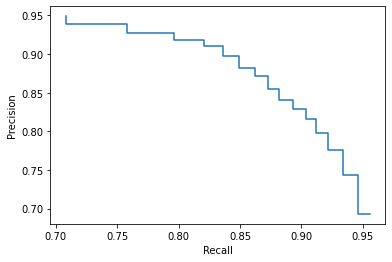

In [ ]:
score_thresholds = np.linspace(0.1, 0.9, 16)
print(score_thresholds)

results2 = list()

for score in score_thresholds:
  tp_total = 0
  fp_total = 0
  fn_total = 0
  # Go over all images
  for image in images:
    # Filter annotations by image_id
    image_id = image['id']
    image_preds = filter_anns_by_image_id(pred, image_id)
    image_gts = filter_anns_by_image_id(gt, image_id)

    # Filter annotations by score
    tmp_preds = filter_preds_by_score(image_preds, score)
    [tp, fp, fn] = calculate_confusion_matrix(image_gts, tmp_preds, iou_threshold = 0.5)
    tp_total = tp_total + tp
    fp_total = fp_total + fp
    fn_total = fn_total + fn
  
  # Append score results
  results2.append(dict(
      score = score,
      tp = tp_total,
      fp = fp_total,
      fn = fn_total,
      precision = _precision(tp_total, fp_total, fn_total),
      recall = _recall(tp_total, fp_total, fn_total),
      f1 = _f1(tp_total, fp_total, fn_total)
  ))


# Precision-Recall curve
precisions2 = [x['precision'] for x in results2]
recalls2 = [x['recall'] for x in results2]
auc = sklearn.metrics.auc(recalls2, precisions2)

# Output
print(f'AUC = {round(auc, 3)}')
PrecisionRecallDisplay(precisions2, recalls2).plot()

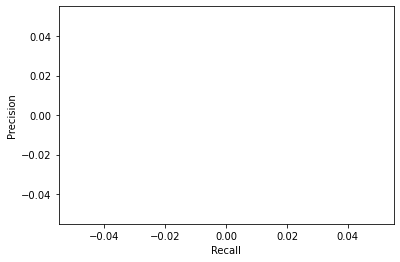

In [ ]:
# Filtered preds by SCORE and IMAGE_ID
preds = filter_anns_by_image_id(pred, IMAGE_ID)
# preds = filter_preds_by_score(preds, SCORE)

# Filtered gts by IMAGE_ID
gts = filter_anns_by_image_id(gt, IMAGE_ID)

# Generate score thresholds
score_thresholds = np.linspace(0.1, 0.9, 9)

# Evaluate all thresholds
results = list()
for score in score_thresholds:
  tmp_preds = filter_preds_by_score(preds, score)
  [tp, fp, fn] = calculate_confusion_matrix(gts, tmp_preds)
  results.append(dict(
      score = score,
      tp = tp,
      fp = fp,
      fn = fn,
      precision = _precision(tp, fp, fn),
      recall = _recall(tp, fp, fn),
      f1 = _f1(tp, fp, fn)
  ))

# Precision-Recall curve
precisions = [x['precision'] for x in results]
recalls = [x['recall'] for x in results]

PrecisionRecallDisplay(precisions, recalls).plot()

# Rest

In [ ]:
match = list()
iou_threshold = 0.5

for gt_sample in gts:
  id = gt_sample['id']
  image_id = gt_sample['image_id']

  for pred_sample in preds:
    iou_value = iou(gt_sample['bbox'], pred_sample['bbox'])
    if iou_value > iou_threshold:
      print(iou_value)




0.5901117559612519
0.9303011757758353
0.8462469922601944
0.709359121892815
0.7668109165536847
0.6980652263215519
0.8144855559128034
0.7637657487676333
0.5670227183530668
0.7904554407228568
0.803466468187812
0.7814445674893777
0.6801682784630843
0.8476556522591968
0.6423261271498701
0.8744478558888349


# Previous

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
No. of GTs: 4
No. of predss: 100
-- TP: 0
-- FP: 160


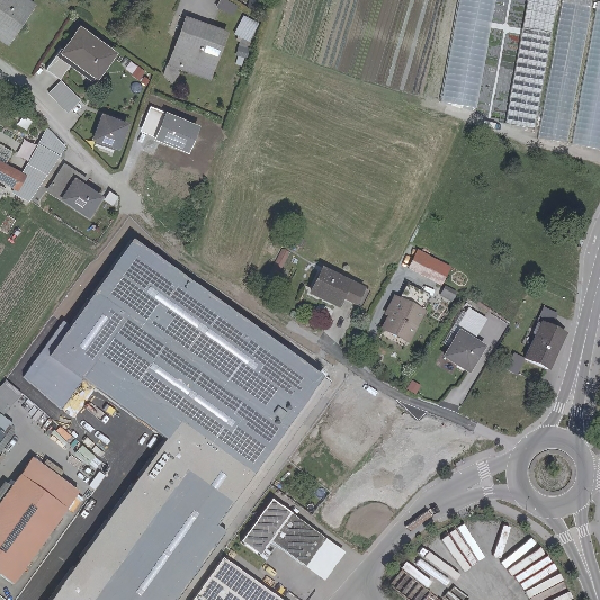

In [ ]:
# Get preds for image_id == 2
sample_preds = [x for x in pred if x['image_id'] == 1]

# Get image 600 x 600
# img = Image.new('RGB', (600, 600), color = 'black')
img = Image.open('/content/3.jpg')
draw = ImageDraw.Draw(img)

# Draw boxes from sample_preds to the image
# IOU_THRESHOLD = 0.6
# for pred in sample_preds:
#   """
#   pred['bbox'] = [x, y, w, h]
#   """
#   for gt in sample_gts:
#     if iou(gt['bbox'], pred['bbox']) >= IOU_THRESHOLD:
#       x, y, w, h = pred['bbox']
#       draw.rectangle([x, y, x+w, y+h], width=1, outline='white')

# img

SCORE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.7

for pred in sample_preds:
  """
  pred['bbox'] = [x, y, w, h]
  """

  is_valid = False

  if pred['score'] >= SCORE_THRESHOLD:
    # Print IOU
    for gt in sample_gts:
      iou_score = iou(gt['bbox'], pred['bbox'])
      if iou_score > IOU_THRESHOLD:
        tp = tp + 1
        x, y, w, h = pred['bbox']
        draw.rectangle([x, y, x+w, y+h], width=1, outline='white')
        break
      else:
        fp = fp + 1
    
    # Draw
    # x, y, w, h = pred['bbox']
    # draw.rectangle([x, y, x+w, y+h], width=1, outline='white')
  

print(f'No. of GTs: {len(sample_gts)}')
print(f'No. of predss: {len(sample_preds)}')
print(f'-- TP: {tp}')
print(f'-- FP: {fp}')

img

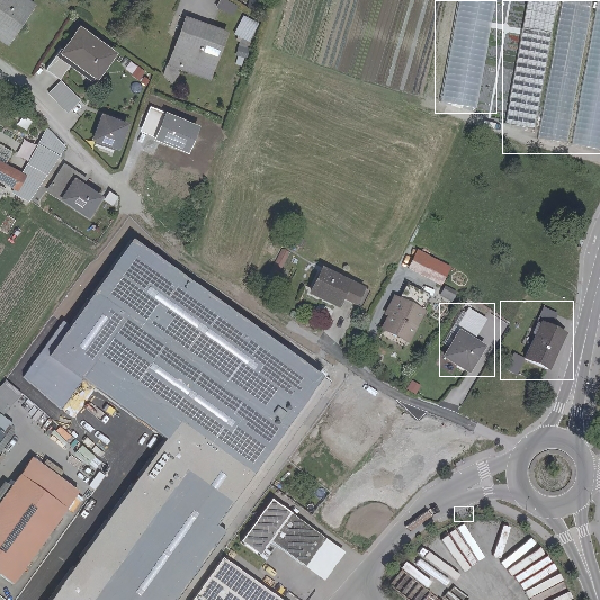

In [ ]:
# 1/3 funguje

with open('/content/annotations.json') as f:
  gt = json.load(f)

sample_gts = [x for x in gt['annotations'] if x['image_id'] == 1]

# Get image 600 x 600
img_gt = Image.open('/content/3.jpg')
draw_gt = ImageDraw.Draw(img_gt)

for sample in sample_gts:
  """
  pred['bbox'] = [x, y, w, h]
  """
  x, y, w, h = sample['bbox']
  draw_gt.rectangle([x, y, x+w, y+h], width=1, outline='white')

img_gt

In [ ]:
def coco_to_xy(box: list) -> list:
  x, y, w, h = box
  return [x, y, x+w, y+h]


def iou(boxA, boxB) -> float:
    """
    boxA/boxB     [x1, y1, x2, y2]
    w             width
    h             height
    inter         intersection
    """
    boxA = coco_to_xy(boxA)
    boxB = coco_to_xy(boxB)

    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    inter_area = max((xB - xA), 0) * max((yB - yA), 0)
    if inter_area == 0:
      return 0

    boxA_area = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxB_area = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    iou = inter_area / float(boxA_area + boxB_area - inter_area)

    return iou

# Compare polygons

In [ ]:
with open('/content/vfnet.bbox.json') as f:
  preds = json.load(f)

sample_preds = [x for x in gt['annotations'] if x['image_id'] == 2]

# Get image 600 x 600
img_gt = Image.open('/content/2.jpg')
draw_gt = ImageDraw.Draw(img_gt)

for sample in sample_gts:
  """
  pred['bbox'] = [x, y, w, h]
  """
  draw_gt.polygon(pred['segmentation'], width=1, outline='white')

img_gt

KeyError: ignored

# IOU

In [ ]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sklearn.metrics
import scipy

class ObjectInstance():
  def __init__(self, box: list, image_id: int, score: float):
    if score == None:
      score = 1

    [x,y,w,h] = box
    self.x1   = x
    self.y1   = y
    self.x2   = x + w
    self.y2   = y + h
    self.width  = w
    self.height = h
    self.image_id = image_id
    self.image_width  = 600
    self.image_height = 600

  @property
  def boxCoco(self):
    return [self.x1, self.y1, self.width, self.height]

  @property
  def boxPoints(self):
    return [[self.x1, self.y1], [self.x2, self.y1], [self.x2, self.y2], [self.x1, self.y2]]

  @property
  def boxXY(self):
    # return [self.x1, self.y1, self.x1 + self.width, self.y1 + self.height]
    return [self.x1, self.y1, self.x2, self.y2]

  @property
  def binMask(self):
    points = np.array([self.boxPoints], dtype=np.int32)
    image = np.zeros([self.image_width, self.image_height], dtype=np.uint8)
    return np.asarray(cv2.fillPoly(image, points, 1))
  
  @property
  def showBinMask(self):
    return plt.imshow(self.binMask)

  def iou(self, target) -> float:
    """
    w       width
    h       height
    inter   intersection
    """
    boxA = self.boxXY
    boxB = target.boxXY

    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    inter_area = max((xB - xA), 0) * max((yB - yA), 0)
    if inter_area == 0:
      return 0

    boxA_area = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxB_area = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    iou = inter_area / float(boxA_area + boxB_area - inter_area)

    return iou

  def jaccard_score(self, target) -> float:
    return sklearn.metrics.jaccard_score(self.binMask, target.binMask, average='micro')
  
  def f1_score(self, target) -> float:
    return sklearn.metrics.f1_score(self.binMask, target.binMask, average='micro')
  
  def recall_score(self, target) -> float:
    return sklearn.metrics.recall_score(self.binMask, target.binMask, average='micro')

# Ground truths 
with open('/content/annotations.json', 'r') as f:
  data = json.load(f)
  gts = data['annotations']
  imgs = data['images']

# Predictions
with open('/content/vfnet.bbox.json', 'r') as f:
  preds = json.load(f)

# Main
pred_bbox = preds[0]['bbox']
gt_bbox = preds[0]


gt_json = {"image_id": 1, "bbox": [307.2895202636719, 263.1874694824219, 63.491729736328125, 46.325225830078125], "score": 0.8165308237075806, "category_id": 1}
pred_json = {"image_id": 1, "bbox": [307.2895202636719, 263.1874694824219, 58.491729736328125, 40.325225830078125], "score": 0.8165308237075806, "category_id": 1}

gt = ObjectInstance(
    image_id=gt_json['image_id'],
    box=gt_json['bbox'],
    score=gt_json['score'],
    )

pred = ObjectInstance(
    image_id=pred_json['image_id'],
    box=pred_json['bbox'],
    score=pred_json['score'],
    )

In [ ]:
def json_to_object_list(input: list):
  result = list()
  for item in input:
    result.append(ObjectInstance(
        box = item['bbox'],
        image_id = item['image_id'],
        score = item.get('score')
    ))

  return result

preds = json_to_object_list(preds)
gts = json_to_object_list(gts)

In [ ]:
IOU_THRESHOLD = 0.8

for pred in preds:
  temp_gts = [gt for gt in gts if gt.image_id == pred.image_id]
  # print(len(temp_gts))

gtx = [gt for gt in gts if gt.image_id == preds[0].image_id]

for pred in preds:
  for gt in gtx:
    iou = pred.iou(gt)
    if iou >= IOU_THRESHOLD:
      print(f'{gt.image_id} = {iou}')

1 = 0.8179901428252718
1 = 0.8407578067585396


In [ ]:
pred =  {"image_id": 1, "bbox": [307.2895202636719, 263.1874694824219, 63.491729736328125, 46.325225830078125], "score": 0.8165308237075806, "category_id": 1}

for pred in preds[:1]:
  gt = [ObjectInstance(image_id=gt['image_id'], box=gt['bbox'], score=gt['score']) for gt in gts['annotations'] if gt['image_id'] == pred['image_id']]

  gt.jaccard_score(pred)

TypeError: ignored

In [ ]:
import json
import numpy as np
import cv2

result = [{"image_id":42,"category_id":18,"bbox":[258.15,41.29,348.26,243.78],"score":0.236},{"image_id":73,"category_id":11,"bbox":[61,22.75,504,609.67],"score":0.318}]
k=1

# segmentation
seg = np.zeros((100,100), dtype='int')
seg[30:70, 30:70] = k

# ground truth
gt = np.zeros((100,100), dtype='int')
gt[30:70, 40:80] = k

# Pixelwise operations
dice = np.sum(seg[gt==k])*2.0 / (np.sum(seg) + np.sum(gt))

print(f'Dice similarity score is {dice}')

Dice similarity score is 0.75


In [ ]:
bbox = result[0]['bbox']

img = np.zeros((600, 600, 1))
cv2.fillPoly(img, pts=bbox, color=(255, 0, 0))
cv2.imshow('tt' ,img)

error: ignored

In [ ]:
def intersect(bbox1, bbox2):
  x1 = max(bbox1.x1, bbox2.x1)
  y1 = max(bbox1.y1, bbox2.y1)
  x2 = min(bbox1.x2, bbox2.x2)
  y2 = min(bbox1.y2, bbox2.y2)
  intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
  return intersection

def iou(bbox1, bbox2):
    intersection = self.intersection(bbox)

    iou = intersection / float(self.area + bbox.area - intersection)
    # return the intersection over union value
    return iou

In [ ]:
class Prediction:
  def __init__(self, image_id, category_id, bbox, score):
    [x, y, width, height] = bbox

    self.x1 = x
    self.y1 = y
    self.x2 = x + width
    self.y2 = y + height
    self.width = width
    self.height = height
    
    @property
    def area(self):
      return (self.width * self.height)


# Data manipulation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content
!unzip '/content/drive/MyDrive/vogis_8000samples.zip'
!mv 'vogis_8000samples' 'vogis'

In [ ]:
!unzip '/content/drive/MyDrive/vogis_600px_z17_2.zip'

In [ ]:
from PIL import Image
import numpy as np
import json
import cv2
from skimage import measure
import os

In [ ]:
CONTOUR_THRESH  = 150

# IMAGE_ID        = 4793
# mask_path       = os.path.join(ROOT, 'gt', f'{str(IMAGE_ID)}.jpg')
# image_path      = os.path.join(ROOT, 'images', f'{str(IMAGE_ID)}.jpg')

def get_vectorized_annotations(mask_path: str, mask_tolerance: int = 4) -> tuple:
  """
  Extracts countors from a binary mask to calculate mask polygons and bounding boxes
  """

  mask = cv2.imread(mask_path)
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

  contours, hierarchy = cv2.findContours(
      mask.copy(), 
      cv2.RETR_TREE,
      cv2.CHAIN_APPROX_SIMPLE, # cv2.CHAIN_APPROX_NONE
      offset=(0, 0)
  )

  boxes = [np.asarray(cv2.boundingRect(cnt), dtype=float).tolist() for cnt in contours if cv2.contourArea(cnt) > CONTOUR_THRESH]
  masks = [cnt for cnt in contours if cv2.contourArea(cnt) > CONTOUR_THRESH]
  # masks = [cv2.convexHull(cnt) for cnt in contours if cv2.contourArea(cnt) > CONTOUR_THRESH]
  masks = [measure.approximate_polygon(np.squeeze(mask), tolerance = mask_tolerance).tolist() for mask in masks]
  return (boxes, masks)


def show_masks(image_path: str, masks: list, tolerance: int = 4) -> Image:
  """
  Draws mask polygons on an image
  """
  image = cv2.imread(image_path)

  for mask in masks:
    mask = np.array(mask).flatten().reshape((-1, 1, 2))
    cv2.polylines(image, [mask], isClosed=True, color=(255, 255, 0), thickness=1)

  return Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 'RGB')


def show_boxes(image_path: str, boxes: list) -> Image:
  """
  Draws bounding boxes on an image
  """

  # cv2.minAreaRect()     highlights the minimum rectangle enclosing a contour (will be rotated)
  # cv2.boxPoints()       obtains the 4 corner points of the obtained rectangle

  image_bb = cv2.imread(image_path)
  [cv2.rectangle(image_bb, (int(box[0]), int(box[1])), (int(box[0])+int(box[2]), int(box[1])+int(box[3])), (255, 255, 0), 1) for box in boxes]

  return Image.fromarray(cv2.cvtColor(image_bb, cv2.COLOR_BGR2RGB), 'RGB')

def create_image_info(image_id: int, file_name: str, image_size: tuple) -> dict():
  """
  Creates dict with image info for COCO dataset
  """
  return dict(
      id        = image_id,
      file_name = file_name,
      width     = image_size[0],
      height    = image_size[1]
  )


def create_annotation_info(annotation_id: int, image_id: int, image_size: tuple, category_id: int, mask_path: str, mask_tolerance: int) -> dict:
  """
  Creates dict with annotation info for COCO dataset
  """

  def get_polygon_area(p: list) -> float:
    """
    Shoelace algorithm
    https://www.omnicalculator.com/math/irregular-polygon-area
    https://stackoverflow.com/questions/451426/how-do-i-calculate-the-area-of-a-2d-polygon
    """
    segments = zip(p, p[1:] + [p[0]])
    return 0.5 * abs(sum(x0*y1 - x1*y0 for ((x0, y0), (x1, y1)) in segments))

  (boxes, polygons) = get_vectorized_annotations(mask_path, mask_tolerance=mask_tolerance)
  result = list()

  for i, (box, polygon) in enumerate(zip(boxes, polygons)):

    result.append(dict(
        id            = annotation_id + len(result),
        image_id      = image_id,
        category_id   = category_id,
        iscrowd       = 0,
        area          = get_polygon_area(polygon),
        bbox          = box,
        segmentation  = [np.asarray(polygon, dtype=float).flatten().tolist()]
    ))

  return result

def generate_coco_annotations(image_dir: str, mask_dir: str, output_file: str, debug: bool = False) -> None:
  """
  Create COCO-styled annotations from images and masks in a folder
  """

  images = list()
  annotations = list()

  for index, sample in enumerate(os.listdir(IMAGE_DIR)):
    if sample == '.DS_Store':
      continue

    image_path  = os.path.join(IMAGE_DIR, sample)
    image_id    = len(images) + 1
    image_size  = Image.open(image_path).size

    annotation_path = os.path.join(MASK_DIR, sample)
    annotation_id   = len(annotations) + 1
    category_id     = 1

    # Generates dict for image info
    image_info = create_image_info(
        image_id    = image_id,
        file_name   = sample,
        image_size  = image_size
    )

    # Generates dict for annotation info
    annotation_info = create_annotation_info(
        image_id          = image_id,
        image_size        = image_size,
        annotation_id     = annotation_id,
        category_id       = category_id,
        mask_path         = annotation_path,
        mask_tolerance    = 4
    )

    if (len(annotation_info) == 0):
      os.remove(image_path)
      os.remove(annotation_path)
      continue

    images.append(image_info)
    annotations = annotations + annotation_info

  # Generate COCO dict
  output = dict(
      info        = dict(description = 'QGIS dataset test',),
      categories  = [dict(id=1, name='building', supercategory='buildings')],
      images      = images,
      annotations = annotations
  )

  # Debugging
  if debug:
    # print(annotations[5])
    pass
  else:
    with open(os.path.join(output_file), 'w') as f:
      f.write(json.dumps(output))

In [ ]:
# Create COCO file
ROOT          = '/content/vogis_8000samples'
IMAGE_DIR     = os.path.join(ROOT, 'images')
MASK_DIR      = os.path.join(ROOT, 'gt')
OUTPUT_FILE   = os.path.join(ROOT, 'annotations.json')

generate_coco_annotations(IMAGE_DIR, MASK_DIR, OUTPUT_FILE)

In [ ]:
import json

with open('/content/vogis_8000samples/annotations.json', 'r') as f:
  data = json.load(f)

print(len(data['annoation']))

3122
